# An LTH of BPSO and Local Search to solve the MKP

Mohammed Alagha

Glasgow, UK

January, 2022

This notebook contains a proof of concept for a low-level teamwork hybrid `LTL` of binary particle swam optimization `BPSO` algorithm and local search to solve the multidimensional knapsack problem `MKP`. 
The code and the notes serve as a blueprint for further improvements on the algorithm. 

The hybrid was tested on small and intermediate size benchmark instances and demonstrated a competetive result in finding all the best known integer objective values. For large scale instances, the hybrid takes long time and finds an objective value with an optimality gap of less than 4%. More ideas will be tested to enhance its performance and reduce computation budget by using different data structures and smarter representative code. 

A gentle introduction about the **multidimensional knapsack problem** can be found here:
https://towardsdatascience.com/the-binary-multidimensional-knapsack-problem-mkp-2559745f5fde

In [1]:
import pandas as pd
import numpy as np
from random import * 
import time as time
from math import ceil
import copy
import operator
import cplex
from docplex.mp.model import Model
from typing import List, Set, Dict, Tuple, Optional

# Class MKP: Multidimensional Knapsack Problem

In [2]:
class Mkp:
    '''
    Mkp class reads certain formatted input (.txt) data files of a MKP instance, populates it, solves 
    the relaxed LP version and returns valuable values and parameters to be used in constructing the 
    heuristic hybrid algorithm solutions.
    '''
    
    
    # --------------------------------------------------------------------------------------------
    def __init__(self, name: str):
        self.name = name
        self.c, self.A, self.b       = self.populateMKP()
        self.nCols, self. nRows      = range(len(self.c)), range(len(self.b))
        self.ObjVal, self.RC, self.y = self.solveLP()
        
    # --------------------------------------------------------------------------------------------
    def populateMKP(self) -> Tuple:
        # populateMKP

        '''
        This function extracts the raw data from a .txt file and populates the objective function
        coefficients (c), the constraints coefficients matrix (A) and the right hand side (b)
        
            m -- number of rows / constraints
            n -- number of columns / variables

        Input:
        ------
            name -- the name of the .txt file that contains the raw data

        returns:
        --------
        A Tuple (c, A, b):
            c -- objective function coefficients array (shape = 1 * n)
            A -- constraints coefficients matrix A (shape = m * n)
            b -- right hand side values (shape = 1 * m)
        '''

        # Opening .txt file to read raw data of an instance
        file = open(str(self.name), 'r')
        data = []
        for line in file:
            splitLine = line.split()
            for i in range(len(splitLine)):
                data.append(splitLine[i])
        file.close()


        # Define parameters
        NumColumns, NumRows, BestOF = int(data.pop(0)), int(data.pop(0)), float(data.pop(0))
        print('This instance has %d variables and %d constraints' %(NumColumns, NumRows))

        if BestOF != 0:
            print('Best known integer objective value for this instance = ', BestOF)
        else:
            print('Best integer objective value for this instance is not indicated')


        # Populating Objective Function Coefficients
        c = np.array([float(data.pop(0)) for i in range(NumColumns)])

        assert type(c) == np.ndarray
        assert len(c)  == NumColumns


        # Populating (A) matrix (size NumRows * NumColumns)
        ConstCoef = np.array([float(data.pop(0)) for i in range(int(NumRows * NumColumns))])
        
        assert type(ConstCoef) == np.ndarray
        assert len(ConstCoef)  == int(NumRows * NumColumns)

        A = np.reshape(ConstCoef, (NumRows, NumColumns)) # reshaping the 1-d ConstCoef into A (m * n)

        assert A.shape == (NumRows, NumColumns)


        # Populating the RHS
        b = np.array([float(data.pop(0)) for i in range(int(NumRows))])
        
        assert len(b) == NumRows
        assert type(b) == np.ndarray

        return (c, A, b)
    
    # --------------------------------------------------------------------------------------------
    def solveLP(self) -> Tuple:
        """
        Creates a continuous LP optimization model of the Multidimensional Knapsack problem by
        relaxing binary constraints on the columns/variables.
        The function processes the instance populated by the (populateMKP(self)) method.
            
        Returns:
        --------
        A Tuple(ObjVal, RC, y):
            ObjVal -- Objective value of the relaxed version of the Mknapsack instance which is an upper bound 
                      on the integer objective value.
            RC     -- Array of reduced cost value of each column/variable (shape = 1 * n)
            y      -- Array of dual values of the rows/constraints (shape = 1 * m)
        """
        mkp = Model('MKP')
        
        x = mkp.continuous_var_list(self.nCols, lb = 0, ub = 1, name = 'x')
        
        constraints = mkp.add_constraints(sum(self.A[i][j] * x[j] for j in self.nCols) <= self.b[i] for i in self.nRows)
        
        profit = mkp.sum(self.c[j] * x[j] for j in self.nCols)
                
        obj = mkp.maximize(profit)
        
        mkp.print_information()

        mkp.solve()
       

        
        ObjVal = mkp.objective_value
        RC     = [x[i].reduced_cost for i in self.nCols]
        y      = mkp.dual_values(constraints)
        
        assert len(RC) == len(self.c)
        assert len(y)  == len(self.b)
        
        print('The LP relaxation upper bound objective value is {:,.3f}'.format(ObjVal))
        
        return (ObjVal, RC, y)
    
    # --------------------------------------------------------------------------------------------
    def normalise_RC(self) -> List:
        '''
        Maps the original reduced costs 'RC' values (that might be -ve, 0 or +ve) to a value between 
        0 and 1 according to the following function:
                        f(x) = (x - a) / b
                        x: original RC value
                        a: absolute value of the minimum RC value
                        b: the maximum RC value
        '''
        a = np.abs(np.min(self.RC))
        b = np.max(self.RC) + a
        
        normalised_RC = [(self.RC[i] + a) / b for i in range(len(self.RC))]
        
        return normalised_RC
    # --------------------------------------------------------------------------------------------
    def getImputedCosts(self) -> List:
        """
        Computes imputed cost per column/variable (x) with the following formula:
                        imputed_cost = sum(y_j * a_ij) for j in nRows, i in nCols

        Definition:
        -----------
            Imputed cost: "For each variable/column, the value of the imputed cost gives the total consumption
                            of resources incured by this column"

        Returns:
        --------
            ImputedCosts -- Array of imputed cost per column/variable
        """
        imputed_cost = [sum(self.y[i] * self.A[i][j] for i in self.nRows) for j in self.nCols]
        
        assert len(imputed_cost) == len(self.c)

        return imputed_cost

    # --------------------------------------------------------------------------------------------
    def getUtilities(self) -> Dict:
        """
        Computes utility and pseudo utility value for each column/variable (x) given the formula:
                    utility(i)    = c(i) / imputed cost(i) for i in nCols

        Returns:
        --------
            utility -- Dictionary with utility value for each column/variable (j)
        """
        imputedCosts = self.getImputedCosts()
    
        utility      = {j: (self.c[j] / imputedCosts[j]) for j in self.nCols}

        return utility
    # --------------------------------------------------------------------------------------------
    def unpack(self) -> List:
        '''
        Returning values of:
            c -- objective function coefficients array (shape = 1 * n)
            A -- constraints coefficients matrix A (shape = m * n)
            b -- right hand side values (shape = 1 * m)
            ObjVal -- Objective value of the relaxed version of the Mknapsack instance which is an upper bound 
                      on the integer objective value.
            RC     -- Array of reduced cost value of each column/variable (shape = 1 * n)
            y      -- Array of dual values of the rows/constraints (shape = 1 * m)
        
        '''
        return (self.c, self.A, self.b, self.ObjVal, self.RC, self.y)
        
    
    

# Particle Class

The idea behind using reduced costs in calculating utilities and initialize the particles' positions with utility values stems from the following facts:
1. Integer optimum solutions are in the vecinity of the optimum LP solution
2. RC values provide hints about promising columns (some sort of explicit pricing), where columns with RC value > 0 get higher chance being selected 

In [3]:
class Particle:
    '''
    Particle class generates the swarm objects (particles).
    
    For each particle, we have:
        dim -- length of the particle
        position -- stores position values of the dimensions of each particle
        velocity -- stores velocity values of the dimensions of each particle
        cols -- a temporary container to store the binary values of each particle (since it is a binary PSO)
        bestPartColVals -- storing the best (encoded binary values) generated by this particle so far
        bestPartPosition -- storing the best position of this particle 
        objective -- storing the objective value obtained by this particle at any given iteration
        bestParticleObj -- storing the best objective value obtained by this particle so far
        
    '''
    def __init__(self, dim, seed):
        self.rnd      = Random(seed)
        self.dim = dim 
        self.position = np.array([float(0) for i in range(self.dim)], dtype = np.float16)
        self.velocity = np.array([float(0) for i in range(self.dim)], dtype = np.float16)
        self.cols = [float(0) for i in range(self.dim)]
        self.bestPartColVals = [0 for i in range(self.dim)]
        self.bestPartPosition = np.array([float(0) for i in range(self.dim)], dtype = np.float16)
        self.objective = float(0)
        self.bestParticleObj = self.objective

    # ---------------------------------------------------------------------------------------------
    def initialize_RC(self) -> None:
        self.position = [norm_RC[j] for j in range(self.dim)]
    # ---------------------------------------------------------------------------------------------
    def initialize_Ua(self):
        for j in range(self.dim):
            if RC[j] == 0:
                self.position[j] = Ua[j] 
            elif RC[j] > 0:
                self.position[j] = Ua[j] * (1 + uniform(1, 1.2)) 
            else:
                self.position[j] = Ua[j] * (1 - uniform(0.8, 1))
    # ---------------------------------------------------------------------------------------------
    def re_init_Ua(self):
        self.position = [Ua[j] for j in range(self.dim)]
        self.bestPartPosition = np.array([float(0) for i in range(self.dim)], dtype = np.float16)
        self.velocity = [float(0) for j in range(self.dim)]
        

# Evaluate Objective function value

In [4]:
def evalObj(cols: List, c: List) -> float:
    '''
    computes the objective function value 
    
    Input:
    ------
        cols -- a list/array of binary values with shape (1 * n) where n is the number of variables/ columns
                a value of 1 means variable is chosen, 0 otherwise
        
        c    -- a list/array of objective function coefficients for all variables/columns
    '''
    obj = float(0)
    obj = np.dot(cols, c) # vectorization to speed up the operation
    return obj

# Feasibility check function

In [5]:
def checkFeasibility(potentialSol: List, j = None) -> bool:
    '''
    checks whether a given binary vector satisfies all constraints
    If (j: int) != None, then the function checks whether the vector still satisfies feasibility constraints
           if variable at index j is set to 1
    
    Input:
    ------
        potentialSol -- a list/array of binary values with shape (1 * n) where n is the number of variables
                        a value of 1 means variable is chosen, 0 otherwise
                
        j            -- an integer value ranging between (0, n -1) indicating the index of a variable to check
                        feasibility if its value becomes 1. Default value of j is None
                        
    Returns:
    --------
        isFeasible -- a boolean value indicating whether the potentialSol satisfies feasibility constraints
    '''
    dim = range(len(b))
    isFeasible = True
    
    if j or j == 0:
        potentialSol[int(j)] = 1
        LHS = [np.dot(potentialSol, A[i]) for i in dim]
        diff = LHS - b
        
        for i in dim:
            if diff[i] > 0:
                potentialSol[int(j)] = 0
                isFeasible = False               
                return isFeasible
        potentialSol[int(j)] = 0
    else:
        LHS = [np.dot(potentialSol, A[i]) for i in dim]
        diff = LHS - b
        
        for i in dim:
            if diff[i] > 0:
                isFeasible = False
                return isFeasible
                
    return isFeasible

# Local Search Function

In [6]:
def localSearch(columns: List, k = 4, f = 1) -> List: # input is swarm[i].cols
    '''
    This function adopts Kong et al (2008) local search scheme
    For any vector of columns, randomly chooses k dimensions and flip their values (0 becomes 1 and vice versa)
    
    Input:
        columns -- a (1 x no. columns) array containing binary values (1 means column was chosen, 0 otherwise)
        k       -- number of variables to be flipped (default = 4 as per Kang et. al 2008)
        f       -- number of times local search is applied to a given solution (default = 1)
    Returns:
        incumbentColumns -- a (1 * no. columns) array containing binary values after restoring feasibility 
                            and enhancing the quality if capacities allow for improvement 
    '''
    incumbentColumns = None
    objectiveValue = float(0)
    
    for i in range(f):
        
        # ------------------------- Flipping values of 4 columns -------------------------- #
        # Choose k columns randomly
        randChosen = sample(range(len(columns)), k)

        # Flip column value (zero becomes one and vice versa)
        for i in randChosen:
            columns[i] = 1 - columns[i]
        # --------------------------------------------------------------------------------- #
        # --------------------------------------------------------------------------------- #

        # ------------------------- Checking solution feasibility ------------------------- #
        # Storing index and utility of the subset columns with value = 1 in a dictionary 
        solutionColIndex = {n: Ua[n] for n in range(len(columns)) if columns[n] == 1}


        # Sorting the dictionary based on utility values in an ascending order
        sortedsolutionColIndex = sorted(solutionColIndex.items(), key = operator.itemgetter(1), reverse = False)
       

        # Check feasibility of the solution after columns values' flipped
        isFeasible = checkFeasibility(columns)
        # --------------------------------------------------------------------------------- #
        # --------------------------------------------------------------------------------- #

        # ---------------- Restoring solution feasibility / Drop Operator ----------------- #

        # If infeasible: restore feasibility by dropping low utility columns
            # else: enhance solution by trying to add more profitable columns (start with higher utility columns)
        while not isFeasible:
                minIndex = int(sortedsolutionColIndex[0][0])
                columns[minIndex] = 0
                sortedsolutionColIndex.pop(0)
                isFeasible = checkFeasibility(columns)
                
        # --------------------------------------------------------------------------------- #
        # --------------------------------------------------------------------------------- #

        # -------------------- Enhancing solution value / Add Operator -------------------- #
        # Objective value after restoring feasibility
        #print(f'before enhancement OF = {evalObj(columns, c)}, columns = {columns}'); print()
        
        # Storing index and utility of the subset columns with value = 0 in a dictionary 
        remainingColIndex = {n: Ua[n] for n in range(len(columns)) if columns[n] == 0}
        

        # Sorting the dictionary based on utility values in a descending order
        sortedRemainingColIndex = sorted(remainingColIndex.items(), key = operator.itemgetter(1), reverse = True)


        # Try to push all possible columns (priority to high utility columns)
        while len(sortedRemainingColIndex) > 0:
            maxIndex = int(sortedRemainingColIndex[0][0])
            if checkFeasibility(columns, maxIndex):
                    columns[maxIndex] = 1
                    #incumbentColumns = columns
            sortedRemainingColIndex.pop(0)

        if evalObj(columns, c) > objectiveValue:
            incumbentColumns = columns
            objectiveValue = evalObj(incumbentColumns, c)
            
        columns = incumbentColumns
        
    return incumbentColumns


# Building the hybrid algorithm - Binary PSO + LS

**General Idea:**

This algorithm is an example of what referred to in the literature as a LTH or **Low-Level Teamwork Hybrid** in which a Population-based-Metaheuristic (P-Metaheuristic) is coupled with a Single-Solution-Metaheuristic (S-Metaheuristic). P-Metaheuristics (such as PSO here) are powerful when exploring the solution space but are weak when it comes to exploitation. This weakness is compensated by the coupling with a S-Metaheuristic such as Local Search in our case. The P-Metaheuristic acts as a global optimizer while the S-Metaheuristic acts as a local one.

**Steps:**

* Determine hyperparameters (no. of iterations, max & min velocity, swarm size, etc.)
* Create and initialize the swarm (position and velocity)
* Run hybrid for the predetermined no. of iterations (Algorithm termination criterion is no. of iterations)
    * Each iteration, every particle generates a solution
    * Local search is applied to the generated solution
    * Feasibility is checked (restored if infeasible) and improvement is applied (Drop-Add operator as per Kang  et. al 2008)
    * Particle's velocity is update and position adjusted accordingly
    * Velocities are clamped if exceed Vmax or fall below Vmin
    * Local and global best positions and solutions are updated - if necessary
    * Subset of particles are re-initialized if objective is not improving for a predetermined no. of iteration
    
**Notes:**

* To introduce diversification and assure larger coverage of the solution space, some particles position values are initialized with the zero vector, the others are intialized with perturbed utility values (particles are physically distributed in different positions to increase diversification)
* Inertia weights in velocity updating equation starts at value of 0.9 at first iteration and decreases linearly to a final value of 0.3. This is to avoid swarm divergance or particles failing to change direction and move back towards promising areas.
* The number of variables flipped in local search decreases linearly to increase diversification early at the begining of the algorithm and then allows for intensification in later iterations.
* Velocity values are clamped to avoid large position updates leading particles beyond the search space
    * Values in this hybrid are adopted from literature as a proof of concept and were not tested and/or optimized!
* Reinitialization of a subset of particles is introduced to introduce more diversity, avoid premature stagnation or being trapped in a local optima (known in the literature as **craziness operator**). This is done to the particle's position and velocity vectors and the particle's best position. It completely erases particles memory and avoids immediately repositionning the particle to its previously found best position -hence lowering diversity effect. IT should be noted that the swarm best particle is excluded from reinitialization at all times.
* The probabilistic decoder used to map the positions and velocities from the continuous domain to the binary domain is the **sigmoid** function. We are transforming the velocity value of each dimension to a probability that decides whether the dimension be a 0 or a 1.

**Future Work:**

* Study the velocity change of particles from one iteration **t** to the next **t + 1** or the **Hamming distance**. (In binary PSO, velocity is interpreted as the number of dimensions that flip value). 
* Optimize the hyperparameters of the algorithm (Conduct a designed experiment (Tagucci orthogonal arrays, full factorial designs with each parameter is a factor that is changed over a range of levels, and find the best combination that results in the best performance)

In [29]:
def buildSolution(numIterations, maxV, minV, n, dim, k_max):
    '''
    This functions uses previously defined classes and functions to build the heuristic solution adopting
    the population based Binary PSO algorithm.
    
    Input:
    ------
        numIterations -- No. of iterations to run the LTH
        maxV, minV    -- Max and Min values of the velocity component of each particle
        n             -- Swarm size (No. of particles)
        dim           -- Dimension of the particle (length of the position or velocity vectors
                         In our case it equals the number of variables/columns
        k_max         -- Maximum number of variables flipped when applying local search
    
    '''

    # Create the swarm
    swarm = [Particle(dim, i) for i in range(n)]

    # Initialize a subset of particles position with Ua perturbed values 
    # 10% swarm initialized with 0, 90% with perturbed Ua values
    for i in range(n):
        if i > n//10:
            swarm[i].initialize_RC()


    # Define global benchmarks
    bestSwarmObjective = float(0)
    GlobalBestPosition = [float(0) for i in range(dim)]
    GlobalBestSolution = [0 for i in range(dim)]
    bestParticle = None
    trackObjective = []; trackObjective.append(bestSwarmObjective)
    trackingCounter = 0
    track_best_particle = []

    print(f'Number of iterations = {numIterations - 1}, swarm size is {n}')
    print(f'Before PSO, best objective = {bestSwarmObjective}')
    print('-------------------------------------------------------------------------------------------------\n')

    iteration = 0
    w_i, w_f = 0.9, 0.3    # initial and final inertia weights
    w = 0.729 # inertia
    c1 = 1.5 # cognitive (particle)
    c2 = 1.5 # social (swarm)

    t1   = time.time()

    while iteration < numIterations:

        if iteration > 0 and iteration % 20 == 0:
            print('iteration = {}, best objective = {:,.3f}'.format(str(iteration), bestSwarmObjective))
            print('global best Particle = {}'.format(str(bestParticle)))
            print('-----------------------------------------------------------------------------------------\n')


        # For each particle in the swarm, generate solution, check and update particle and swarm metrics -- if nec
        for i in range(n):
            swarm[i].cols = [0 for k in range(dim)]
            # Probabilistically choose columns to include in the solution (Probabilistic decoder)
            for j in range(dim): # for each dimension in the particle position
                sigmoid = (1/(1 + np.exp(- swarm[i].position[j])))
                if random() < sigmoid:
                    swarm[i].cols[j] = 1

            '''
            No. of flipped columns decreases linearly with each iteration
            This allows for high exploration/diversification in initial iterations and exploitation/intensification 
            in later iteration
            '''
            swarm[i].cols = localSearch(swarm[i].cols, k_max)# * ceil((numIterations - iteration) / numIterations))

            # Evalaute objective
            swarm[i].objective = evalObj(swarm[i].cols, c)

            # update particle best objective, position and columns values if better values are found
            if swarm[i].objective > swarm[i].bestParticleObj: 
                swarm[i].bestParticleObj = swarm[i].objective
                swarm[i].bestPartColVals = copy.copy(swarm[i].cols) #swarm[i].cols
                swarm[i].bestPartPosition = copy.copy(swarm[i].position) #swarm[i].position

                # update global best objective, position and columns values if better values are found
                if swarm[i].bestParticleObj > bestSwarmObjective:
                    bestSwarmObjective = swarm[i].bestParticleObj
                    GlobalBestPosition = copy.copy(swarm[i].position)
                    GlobalBestSolution = copy.copy(swarm[i].bestPartColVals)
                    bestParticle       = i

            # update velocities and positions
            for k in range(dim): 
                r1, r2 = random(), random()
                #w = w_f + (w_i - w_f)*((numIterations - iteration) / numIterations)
                swarm[i].velocity[k] = ( (w * swarm[i].velocity[k]) +
                  (c1 * r1 * (swarm[i].bestPartPosition[k] - swarm[i].position[k])) +  
                  (c2 * r2 * (GlobalBestPosition[k] - swarm[i].position[k])) )  

                # Velocity clamping changes not only the step size, but also the direction in which a particle moves
                if swarm[i].velocity[k] < minV:
                    swarm[i].velocity[k] = minV
                elif swarm[i].velocity[k] > maxV:
                    swarm[i].velocity[k] = maxV

                # Update position using new velocity
            for k in range(dim): 
                swarm[i].position[k] += swarm[i].velocity[k]
        
        # Tracking change of the objective function value
        trackObjective.append(bestSwarmObjective)
        if trackObjective[-1] == trackObjective[-2]:
            trackingCounter += 1        
        # Reinitialize a subset of particles if objective value does not change for a number of iterations
        if trackingCounter > 10:
            trackingCounter = 0
            PerturbationSample = set(sample(range(len(swarm)), len(swarm) // 3))
            PerturbationSample.discard(bestParticle)

            for g in PerturbationSample:
                swarm[g].re_init_Ua()
       
        # Track best particle 
        track_best_particle.append(bestParticle)
        
        iteration += 1
        # End While

    t2 = time.time()

    timeElapsed = t2 - t1
    
    print('\n After PSO, best objective = {:,.3f}'.format(bestSwarmObjective))
    print('Time elapsed = {:,.5f} seconds, or {:0.2f} minutes'.format(timeElapsed, timeElapsed/60.0))
    
    history = {'objective_history': trackObjective, 'particle_history': track_best_particle}
    return history
    

# Creating an instance and obtaining valuable information 

In [36]:
mknap01 = Mkp('mknap01_5.txt')

This instance has 28 variables and 10 constraints
Best known integer objective value for this instance =  12400.0
Model: MKP
 - number of variables: 28
   - binary=0, integer=0, continuous=28
 - number of constraints: 10
   - linear=10
 - parameters: defaults
 - objective: maximize
 - problem type is: LP
The LP relaxation upper bound objective value is 12,462.104


In [37]:
c, A, b, ObjVal, RC, y = mknap01.unpack()
Ua = mknap01.getUtilities() # utility values of columns
norm_RC = mknap01.normalise_RC()

In [42]:
import matplotlib.pyplot as plt

In [14]:
RC_df = pd.DataFrame({'RC': RC})

In [16]:
norm_RC = pd.DataFrame({'RC': norm_RC})

In [178]:
min_RC = RC_df['RC'].min()
RC_norm = RC_df + np.abs(min_RC)
max_RC_norm = RC_norm.max()
RC_norm = RC_norm/max_RC_norm

In [179]:
RC_norm == norm_RC

,RC
0,True
1,True
2,True
3,True
4,True
...,...
95,True
96,True
97,True
98,True


In [12]:
def plot_hist(x, color):
    return x.hist(color = color)

Text(0.5, 1.0, 'Normalised RC Values')

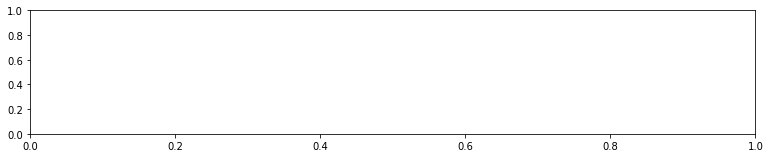

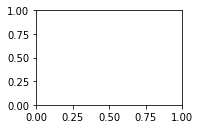

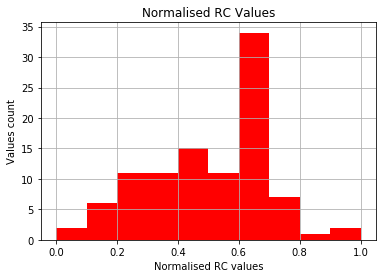

In [18]:
plt.figure(figsize = (13, 5))
plt.subplot(2, 1, 1)
plot_hist(RC_df, color = 'blue')
plt.xlabel('RC values')
plt.ylabel('Values count')
plt.title('Actual RC Values')
plt.subplot(2, 2, 1)
plot_hist(norm_RC, color = 'red')
plt.xlabel('Normalised RC values')
plt.ylabel('Values count')
plt.title('Normalised RC Values')

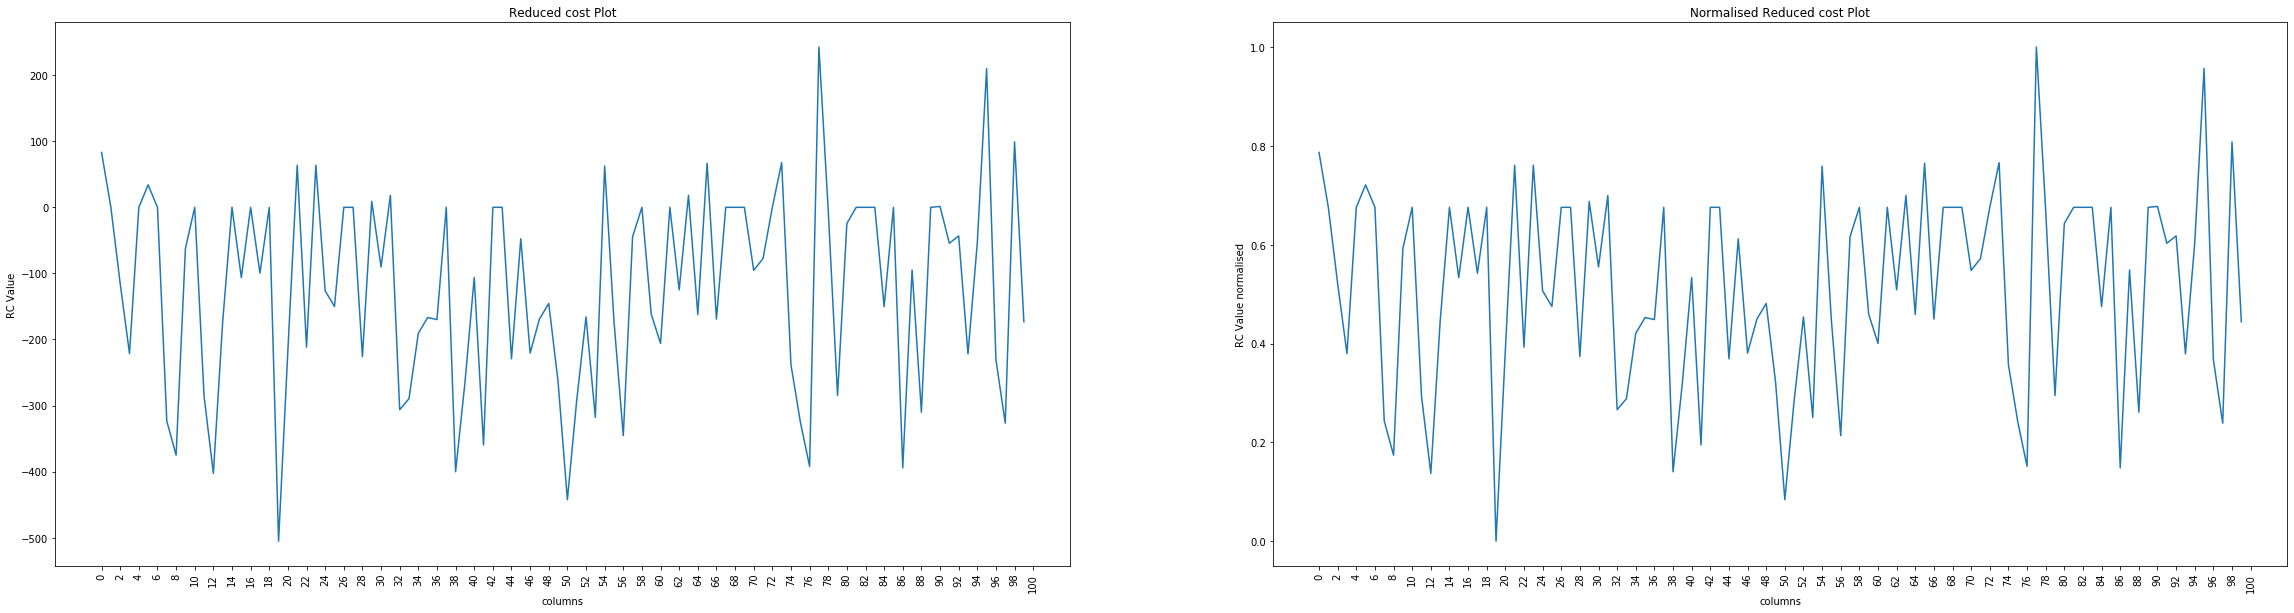

In [162]:
plt.figure(figsize = (40, 10))
plt.subplot(1,2,1)
plt.plot(np.arange(0, len(c)), RC_df['RC'])
plt.xticks(np.arange(0, len(c)+2, step = 2), rotation = 'vertical')
plt.xlabel('columns')
plt.ylabel('RC Value')
plt.title('Reduced cost Plot')
plt.subplot(1,2,2)
plt.plot(np.arange(0, len(c)), RC_norm['RC'])
plt.xticks(np.arange(0, len(c)+2, step = 2), rotation = 'vertical')
plt.xlabel('columns')
plt.ylabel('RC Value normalised')
plt.title('Normalised Reduced cost Plot');

In [163]:
np.argmax(RC_df), np.argmin(RC_df), np.var(RC_df)

(77,
 19,
 RC    22415.220138
 dtype: float64)

In [164]:
np.argmax(RC_norm), np.argmin(RC_norm), np.var(RC_norm)

(77,
 19,
 RC    0.040071
 dtype: float64)

In [40]:
history = buildSolution(numIterations = 101, maxV = 10, minV = -10, n = len(c), dim = len(c), k_max = 10)

Number of iterations = 100, swarm size is 28
Before PSO, best objective = 0.0
-------------------------------------------------------------------------------------------------

iteration = 20, best objective = 12,400.000
global best Particle = 4
-----------------------------------------------------------------------------------------

iteration = 40, best objective = 12,400.000
global best Particle = 4
-----------------------------------------------------------------------------------------

iteration = 60, best objective = 12,400.000
global best Particle = 4
-----------------------------------------------------------------------------------------

iteration = 80, best objective = 12,400.000
global best Particle = 4
-----------------------------------------------------------------------------------------

iteration = 100, best objective = 12,400.000
global best Particle = 4
-----------------------------------------------------------------------------------------


 After PSO, best obje

In [49]:
history_pd = pd.DataFrame(history['objective_history'])

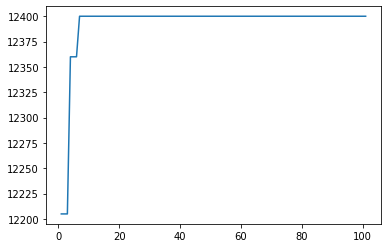

In [51]:
plt.plot(history_pd[1:])